<a href="https://colab.research.google.com/github/chany-ahn/Directed-Reading-McGill/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import constraints

from pyro.nn import AutoRegressiveNN

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

using the CPU


In [5]:
# tickers we want to use: Apple, Amazon, Bitcoin, Tesla, and Uber
tickers = ['AAPL','AMZN','BTC-USD','TSLA','UBER']

# Data Exploration

In [6]:
aapl_data = pd.read_csv("/content/drive/MyDrive/ticker_data/AAPL.csv") # apple
amzn_data = pd.read_csv("/content/drive/MyDrive/ticker_data/AMZN.csv") # amazon
btc_data = pd.read_csv("/content/drive/MyDrive/ticker_data/BTC-USD.csv") # bitcoin
tsla_data = pd.read_csv("/content/drive/MyDrive/ticker_data/TSLA.csv") # tesla
uber_data = pd.read_csv("/content/drive/MyDrive/ticker_data/UBER.csv")

data = [aapl_data, amzn_data, btc_data, tsla_data, uber_data]
for i in range(len(data)):
  df = data[i]
  df = df[df.columns.drop(['Open','High','Low','Volume','Dividends',
           'Stock Splits','Change','Gain','Loss','ema10'])]
  df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
  data[i] = df
data

[            Date       Close  bol_middle_band  bol_upper_band  bol_lower_band  \
 0     2017-03-17   33.043228              NaN             NaN             NaN   
 1     2017-03-20   33.390217              NaN             NaN             NaN   
 2     2017-03-21   33.007828              NaN             NaN             NaN   
 3     2017-03-22   33.380775              NaN             NaN             NaN   
 4     2017-03-23   33.262760              NaN             NaN             NaN   
 ...          ...         ...              ...             ...             ...   
 1254  2022-03-10  158.520004       165.281501      174.181123      156.381879   
 1255  2022-03-11  154.729996       164.412001      173.856644      154.967359   
 1256  2022-03-14  150.619995       163.511001      174.500293      152.521708   
 1257  2022-03-15  155.089996       162.821500      174.106520      151.536481   
 1258  2022-03-16  159.589996       162.161501      172.535017      151.787985   
 
             r

In [7]:
data_processed = []
# Remove this later if you can figure out why it's happening
for df,ticker in zip(data,tickers):
  cols = list(df)
  new_cols = {col : col + "_" + ticker for col in cols}
  df.rename(columns=new_cols, inplace=True)
  data_processed.append(df)

data_processed

[       Date_AAPL  Close_AAPL  bol_middle_band_AAPL  bol_upper_band_AAPL  \
 0     2017-03-17   33.043228                   NaN                  NaN   
 1     2017-03-20   33.390217                   NaN                  NaN   
 2     2017-03-21   33.007828                   NaN                  NaN   
 3     2017-03-22   33.380775                   NaN                  NaN   
 4     2017-03-23   33.262760                   NaN                  NaN   
 ...          ...         ...                   ...                  ...   
 1254  2022-03-10  158.520004            165.281501           174.181123   
 1255  2022-03-11  154.729996            164.412001           173.856644   
 1256  2022-03-14  150.619995            163.511001           174.500293   
 1257  2022-03-15  155.089996            162.821500           174.106520   
 1258  2022-03-16  159.589996            162.161501           172.535017   
 
       bol_lower_band_AAPL   rsi_AAPL  momemntum_AAPL  rate of change_AAPL  \
 0      

In [8]:
# join the data into one dataframe by the latest starting date
df = pd.concat(data_processed, axis=1, join='inner')
df = df.dropna()
date = df['Date_AAPL']
df = df[df.columns.drop(list(df.filter(regex='Date')))]
df = pd.concat([date,df], axis=1)
df = df.rename(columns={'Date_AAPL':'Date'})
df.head()

,Date,Close_AAPL,bol_middle_band_AAPL,bol_upper_band_AAPL,bol_lower_band_AAPL,rsi_AAPL,momemntum_AAPL,rate of change_AAPL,ema14_AAPL,Close_AMZN,...,rate of change_TSLA,ema14_TSLA,Close_UBER,bol_middle_band_UBER,bol_upper_band_UBER,bol_lower_band_UBER,rsi_UBER,momemntum_UBER,rate of change_UBER,ema14_UBER
19,2017-04-13,33.293442,33.609732,34.332862,32.886602,52.250435,-0.616062,3229.344177,33.620167,884.669983,...,5979.999924,58.659156,44.160000,41.5165,45.135762,37.897237,60.997072,2.650002,4315.999985,42.355592
20,2017-04-17,33.477551,33.631448,34.309426,32.953470,54.922426,-0.441395,3247.755051,33.601151,901.989990,...,5928.799820,58.876335,42.610001,41.5685,45.219433,37.917567,54.450266,1.660000,4161.000061,42.389514
21,2017-04-18,33.328846,33.628379,34.311288,32.945471,32.336711,-0.842655,3232.884598,33.564844,903.780029,...,5904.999924,59.032823,42.450001,41.8360,44.862524,38.809476,54.119693,2.510002,4145.000076,42.397578
22,2017-04-19,33.206104,33.638293,34.289569,32.987017,27.248590,-0.788372,3220.610428,33.517012,899.200012,...,6010.400009,59.308980,42.169998,41.9465,44.848472,39.044527,53.979232,2.369999,4116.999817,42.367234
23,2017-04-20,33.621536,33.650331,34.290818,33.009845,41.840199,-0.287968,3262.153625,33.530949,902.059998,...,5950.199890,59.468049,44.310001,42.0975,45.158800,39.036200,64.860679,3.900002,4331.000137,42.626270


## Plotting each technical indicator

### Bollinger Bands

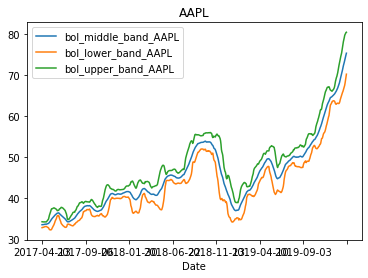

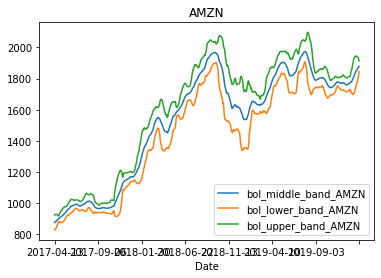

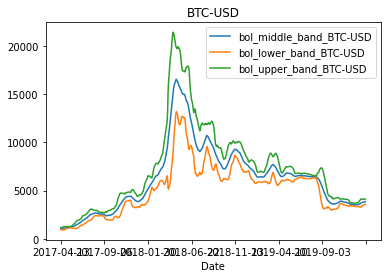

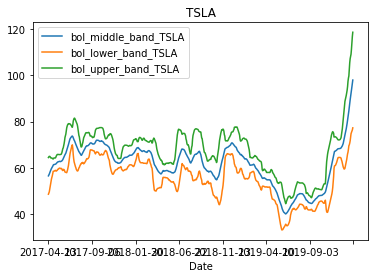

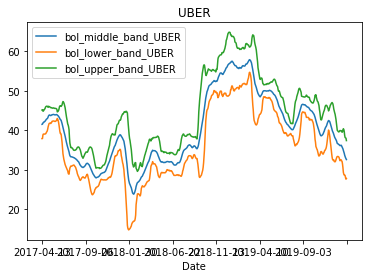

In [9]:
for ticker in tickers:
  df[['Date','bol_middle_band_'+ticker,'bol_lower_band_'+ticker, 'bol_upper_band_'+ticker]].plot(kind='line', x='Date', title=ticker)

### RSI

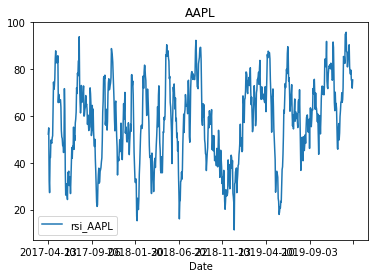

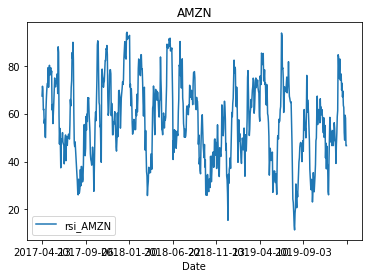

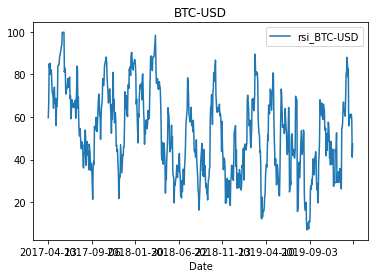

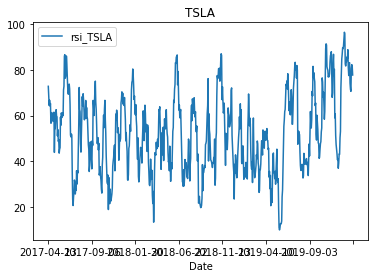

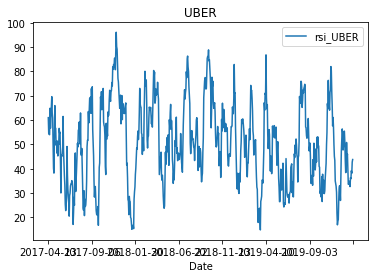

In [10]:
for ticker in tickers:
  df.plot(kind='line',x="Date",y="rsi_"+ticker,title=ticker)

### Exponential Moving Average

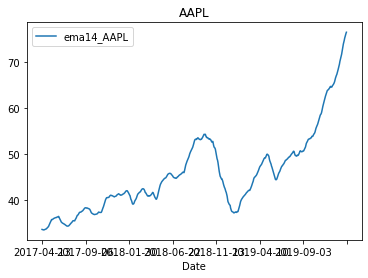

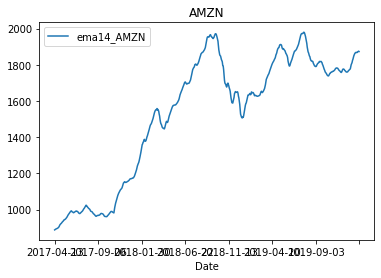

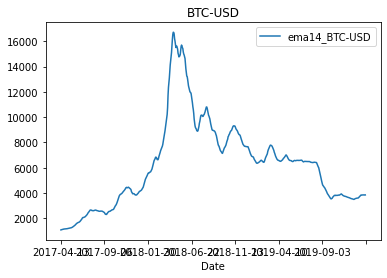

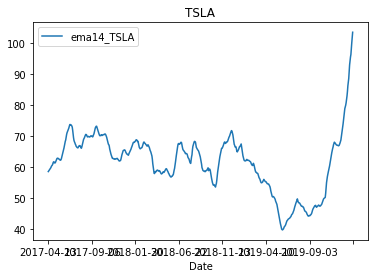

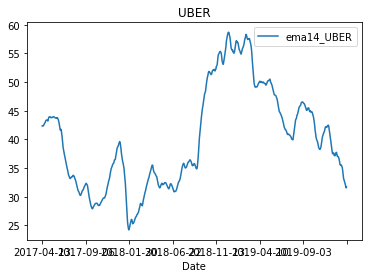

In [11]:
for ticker in tickers:
  df.plot(kind="line",x="Date",y="ema14_"+ticker,title=ticker)

### Momentum

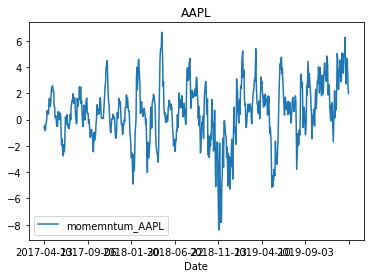

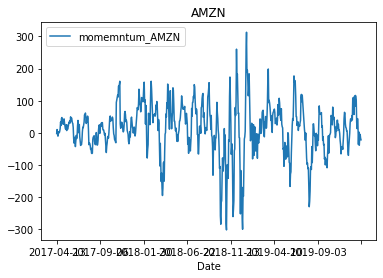

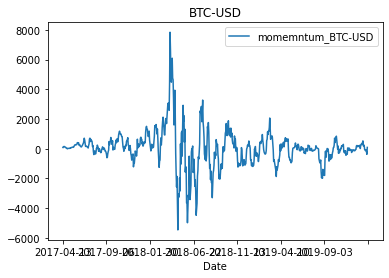

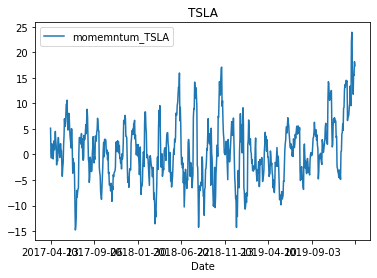

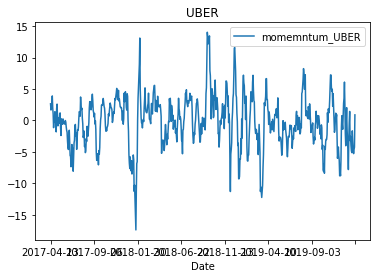

In [12]:
for ticker in tickers:
  df.plot(kind='line',x='Date',y='momemntum_'+ticker,title=ticker)

### Rate of Change

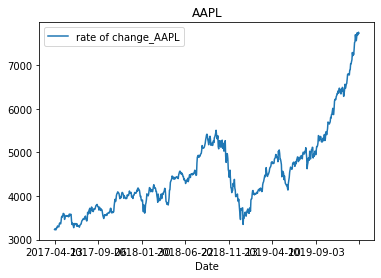

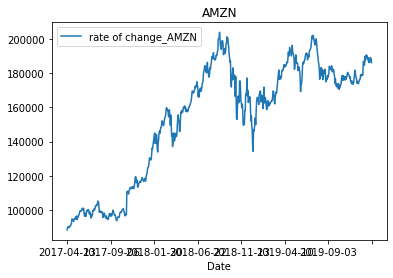

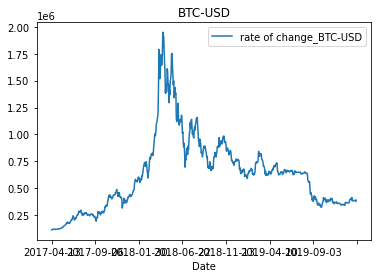

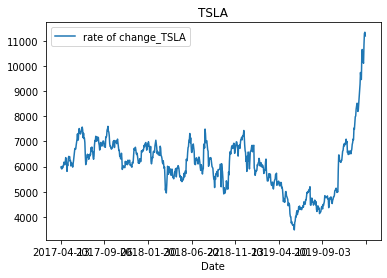

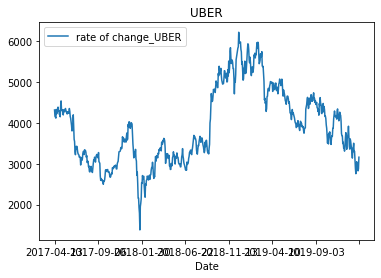

In [13]:
for ticker in tickers:
  df.plot(kind='line',x='Date',y='rate of change_'+ticker, title=ticker)

# Model

### Creating the data

In [22]:
y = df.filter(regex='Close')
x = df[df.columns.drop(list(df.filter(regex='Unnamed')))].drop('Date',axis=1)

,Close_AAPL,bol_middle_band_AAPL,bol_upper_band_AAPL,bol_lower_band_AAPL,rsi_AAPL,momemntum_AAPL,rate of change_AAPL,ema14_AAPL,Close_AMZN,bol_middle_band_AMZN,...,rate of change_TSLA,ema14_TSLA,Close_UBER,bol_middle_band_UBER,bol_upper_band_UBER,bol_lower_band_UBER,rsi_UBER,momemntum_UBER,rate of change_UBER,ema14_UBER
19,33.293442,33.609732,34.332862,32.886602,52.250435,-0.616062,3229.344177,33.620167,884.669983,876.231500,...,5979.999924,58.659156,44.160000,41.5165,45.135762,37.897237,60.997072,2.650002,4315.999985,42.355592
20,33.477551,33.631448,34.309426,32.953470,54.922426,-0.441395,3247.755051,33.601151,901.989990,878.715500,...,5928.799820,58.876335,42.610001,41.5685,45.219433,37.917567,54.450266,1.660000,4161.000061,42.389514
21,33.328846,33.628379,34.311288,32.945471,32.336711,-0.842655,3232.884598,33.564844,903.780029,881.056003,...,5904.999924,59.032823,42.450001,41.8360,44.862524,38.809476,54.119693,2.510002,4145.000076,42.397578
22,33.206104,33.638293,34.289569,32.987017,27.248590,-0.788372,3220.610428,33.517012,899.200012,883.856003,...,6010.400009,59.308980,42.169998,41.9465,44.848472,39.044527,53.979232,2.369999,4116.999817,42.367234
23,33.621536,33.650331,34.290818,33.009845,41.840199,-0.287968,3262.153625,33.530949,902.059998,886.556003,...,5950.199890,59.468049,44.310001,42.0975,45.158800,39.036200,64.860679,3.900002,4331.000137,42.626270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,78.416306,73.644362,79.717420,67.571304,79.623214,4.657295,7741.630554,75.269867,1864.719971,1860.930499,...,10109.999847,96.475018,30.410000,33.7170,38.733186,28.700814,35.859128,-4.570000,2940.999985,32.460616
715,77.884903,74.093978,80.021462,68.166495,75.421287,4.472771,7688.490295,75.618538,1892.000000,1865.916498,...,10844.000244,98.203683,30.760000,33.3675,38.178680,28.556320,39.147289,-5.269999,2976.000023,32.233867
716,78.162910,74.564629,80.204879,68.924379,74.912050,3.569862,7716.291046,75.957788,1887.459961,1870.964496,...,11291.200256,100.298126,29.270000,33.0665,38.109163,28.023837,38.113210,-4.619999,2827.000046,31.838685
717,78.539330,74.998006,80.456430,69.539583,71.902640,2.361870,7753.932953,76.301993,1884.579956,1875.543494,...,11344.000244,102.183709,29.799999,32.8270,38.012033,27.641966,42.720630,-4.240002,2879.999924,31.566860


## Set up the model